In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [3]:
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense

Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [5]:
!pip install aix360

In [6]:
from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier
from aix360.algorithms.protodash import ProtodashExplainer
from aix360.datasets.heloc_dataset import HELOCDataset

If you see an error message about the missing data, then you must upload the heloc_data.cvs file into the folder /usr/local/lib/python3.7/dist-packages/aix360/datasets/../data/heloc_data

In [7]:
heloc = HELOCDataset()
df = heloc.dataframe()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 24)
pd.set_option('display.width', 1000)

Using Heloc dataset:  /usr/local/lib/python3.7/dist-packages/aix360/datasets/../data/heloc_data/heloc_dataset.csv


Task 1: Display the first 10, or so, of the data rows from the imported file...

Task 2: Display the numbers of "Good" and "Bad" applicants...

Task 3: Create a histogram to observe the distribution of values for certain features.

**TASK 1 SOLUTION**

In [8]:
df.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
ExternalRiskEstimate,55,61,67,66,81,59,54,68,59,61
MSinceOldestTradeOpen,144,58,66,169,333,137,88,148,324,79
MSinceMostRecentTradeOpen,4,15,5,1,27,11,7,7,2,4
AverageMInFile,84,41,24,73,132,78,37,65,138,36
NumSatisfactoryTrades,20,2,9,28,12,31,25,17,24,19
NumTrades60Ever2DerogPubRec,3,4,0,1,0,0,0,0,0,0
NumTrades90Ever2DerogPubRec,0,4,0,1,0,0,0,0,0,0
PercentTradesNeverDelq,83,100,100,93,100,91,92,83,85,95
MSinceMostRecentDelq,2,-7,-7,76,-7,1,9,31,5,5
MaxDelq2PublicRecLast12M,3,0,7,6,7,4,4,6,4,4


**TASK 2 SOLUTION**

Displaying the number of good and bad applicants we have:

In [9]:
print("Number of \"Good\" applicants:", np.sum(df['RiskPerformance']=='Good'))

Number of "Good" applicants: 5000


Displaying the number of bad applicants, we have:

In [10]:
print("Number of \"Bad\" applicants:", np.sum(df['RiskPerformance']=='Bad'))

Number of "Bad" applicants: 5459


**TASK 3 SOLUTION**

Displaying histogram of certain attributes to show variations of values, we have:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fb2a24b90>]],
      dtype=object)

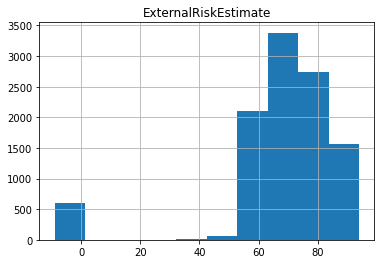

In [11]:
df.hist(column=['ExternalRiskEstimate'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fb293c790>]],
      dtype=object)

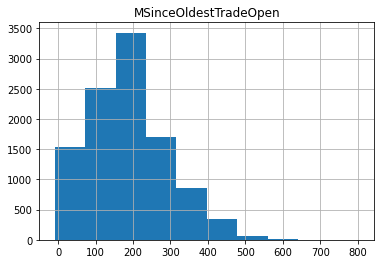

In [12]:
df.hist(column=['MSinceOldestTradeOpen'])

In [15]:
(Data, x_train, x_test, y_train_b, y_test_b) = heloc.split()

In [16]:
Z = np.vstack((x_train, x_test))
Zmax = np.max(Z, axis=0)
Zmin = np.min(Z, axis=0)

In [17]:
print(Zmin)

[0 0 0 4 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
print(Zmax)

[ 94 803 383 383  79  19  19 100  83   9   8 104  19 100  24  66  66 232
 471  32  23  18 100]


Task 4 (for advanced students): Normalise the training and test data such that all values are in the range [-0.5, 0.5]

**TASK 4 SOLUTION**

Normalizing the training and test data such that all values are in the range -0.5 and 0.5, we have:

In [22]:
def normalize(V):
    VN = (V - Zmin)/(Zmax - Zmin)
    VN = VN - 0.5
    return(VN)

In [28]:
print(normalize(x_train[2:3]))

[[ 0.12765957 -0.29078456 -0.4921671  -0.41029024 -0.23417722 -0.5
  -0.5         0.5        -0.5         0.27777778  0.5        -0.29807692
   0.13157895 -0.12       -0.5        -0.48484848 -0.48484848 -0.13362069
  -0.3089172  -0.1875     -0.2826087  -0.27777778  0.44      ]]


In [23]:
N = normalize(Z)
xn_train = N[0:x_train.shape[0], :]
xn_test  = N[x_train.shape[0]:, :]

In [29]:
def nn_small():
    model = Sequential()
    model.add(Dense(10, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))    
    return model

In [30]:
np.random.seed(1) 
tf.set_random_seed(2) 

class_names = ['Bad', 'Good']

In [31]:
def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted)


In [32]:
nn = nn_small()
nn.compile(loss=fn, optimizer='adam', metrics=['accuracy'])
nn.summary()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________


In [33]:
nn.fit(xn_train, y_train_b, batch_size=128, epochs=500, verbose=1, shuffle=False)


Epoch 1/500
7403/7403 [==============================] - 0s 53us/step - loss: 0.6878 - accuracy: 0.5346
Epoch 2/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.6641 - accuracy: 0.6414
Epoch 3/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.6244 - accuracy: 0.6996
Epoch 4/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5931 - accuracy: 0.7093
Epoch 5/500
7403/7403 [==============================] - 0s 11us/step - loss: 0.5766 - accuracy: 0.7130
Epoch 6/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5679 - accuracy: 0.7196
Epoch 7/500
7403/7403 [==============================] - 0s 9us/step - loss: 0.5627 - accuracy: 0.7220
Epoch 8/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5591 - accuracy: 0.7254
Epoch 9/500
7403/7403 [==============================] - 0s 10us/step - loss: 0.5566 - accuracy: 0.7248
Epoch 10/500
7403/7403 [==============================] - 0s 9us

In [34]:
score = nn.evaluate(xn_test, y_test_b, verbose=0) #Compute test set accuracy
print('Test accuracy:', score[1])

Test accuracy: 0.7200161814689636


In [35]:
p_test = nn.predict_classes(xn_test) # Use trained neural network to predict test points
p_test = p_test.reshape((p_test.shape[0],1))

In [36]:
# Store (normalized) instances that were predicted as Bad
z_test = np.hstack((xn_test, p_test)) 
z_test_bad = z_test[z_test[:,-1]==0, :]

In [37]:
print(z_test_bad[8])

[ 0.21276596 -0.35554172 -0.48694517 -0.40501319 -0.32278481 -0.5
 -0.5         0.36       -0.42771084 -0.05555556  0.16666667 -0.36538462
 -0.44736842  0.07       -0.5        -0.5        -0.5        -0.20258621
 -0.2940552  -0.46875    -0.41304348 -0.44444444 -0.07        0.        ]


In [38]:
# Store (unnormalized) instances that were predicted as Bad
zun_test = np.hstack((x_test, p_test)) 
zun_test_bad = zun_test[zun_test[:,-1]==0, :]

In [39]:
print(zun_test_bad[8])

[ 67 116   5  40  14   0   0  86   6   4   6  14   1  57   0   0   0  69
  97   1   2   1  43   0]


In [41]:
idx = 8

X = xn_test[idx].reshape((1,) + xn_test[8].shape)

# attach the prediction made by the model to X
X = np.hstack((X, nn.predict_classes(X).reshape((1,1))))

In [42]:
explainer = ProtodashExplainer()
(W, S, setValues) = explainer.explain(X, z_test_bad, m=5) # Return weights W, Prototypes S and objective function values

Task 5: Modify the input parameters for the ProtodashExplainer such that comparisons against 10 closest cases classified as good are being performed.

**TASK 5 SOLUTION**

First we score normalized instances that was predicted as good 

In [45]:
z_test = np.hstack((xn_test, p_test)) 
z_test_good = z_test[z_test[:,-1]==0, :]

In [46]:
print(z_test_good[10])

[ 0.12765957 -0.46513076 -0.49477807 -0.4762533  -0.42405063 -0.5
 -0.5         0.5        -0.5         0.27777778  0.5        -0.43269231
 -0.28947368 -0.07       -0.5        -0.5        -0.5        -0.07758621
 -0.33651805 -0.40625    -0.36956522 -0.33333333  0.5         0.        ]


In [54]:
idy = 10

Y = xn_test[idx].reshape((1,) + xn_test[10].shape)

# attach the prediction made by the model to X
Y = np.hstack((Y, nn.predict_classes(Y).reshape((1,1))))

Now, modifying the input parameters for the ProtodashEXPLORER such that comparisons against 10 closest cases classified as good are being performed, we have:

In [55]:
explainer = ProtodashExplainer()
(W, S, setValues) = explainer.explain(Y, z_test_good, m=10)

In [56]:
explainer

In [50]:
dfs = pd.DataFrame.from_records(zun_test[S, 0:-1].astype('double'))
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_test[S[i], -1])]) # Append class names
dfs[23] = RP
dfs.columns = df.columns  
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Calculate normalized importance weights
dfs.transpose()

,0,1,2,3,4,5,6,7,8,9
ExternalRiskEstimate,81.0,52.0,82.0,82.0,77.0,76.0,87.0,66.0,86.0,68.0
MSinceOldestTradeOpen,300.0,197.0,191.0,111.0,154.0,94.0,0.0,204.0,264.0,178.0
MSinceMostRecentTradeOpen,2.0,5.0,12.0,18.0,3.0,2.0,32.0,6.0,5.0,7.0
AverageMInFile,90.0,78.0,98.0,67.0,55.0,49.0,97.0,89.0,134.0,74.0
NumSatisfactoryTrades,18.0,17.0,9.0,4.0,31.0,25.0,16.0,20.0,17.0,30.0
NumTrades60Ever2DerogPubRec,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NumTrades90Ever2DerogPubRec,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PercentTradesNeverDelq,100.0,71.0,90.0,100.0,100.0,100.0,100.0,100.0,100.0,97.0
MSinceMostRecentDelq,0.0,3.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MaxDelq2PublicRecLast12M,7.0,4.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0


In [51]:
z = z_test_bad[S, 0:-1] # Store the prototypes
eps = 1e-10 # Small constant to guard against divide by zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]): # Compute feature similarity for each prototype
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(X[0, j] - z[i,j])/(np.std(z[:, j])+eps))
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns = df.columns[:-1]
dfw.transpose()        

,0,1,2,3,4,5,6,7,8,9
ExternalRiskEstimate,0.20,0.11,0.24,0.15,0.07,0.06,1.00,0.04,0.31,0.65
MSinceOldestTradeOpen,0.91,0.30,0.25,0.40,0.75,0.70,0.62,0.49,0.16,0.31
MSinceMostRecentTradeOpen,0.89,0.83,0.24,0.86,0.88,0.84,0.88,0.06,0.84,0.16
AverageMInFile,0.90,0.57,0.85,0.96,0.86,0.96,0.76,0.05,0.20,0.52
NumSatisfactoryTrades,0.94,0.67,0.30,0.80,0.09,0.64,0.94,0.34,0.60,0.30
NumTrades60Ever2DerogPubRec,1.00,1.00,0.62,0.23,1.00,0.03,0.62,0.38,0.62,1.00
NumTrades90Ever2DerogPubRec,1.00,1.00,1.00,0.62,1.00,0.03,1.00,0.62,1.00,1.00
PercentTradesNeverDelq,0.85,0.91,0.05,0.46,0.74,0.74,0.47,0.26,0.94,0.74
MSinceMostRecentDelq,0.60,0.10,0.74,0.37,0.33,0.33,0.55,0.34,0.96,0.33
MaxDelq2PublicRecLast12M,1.00,1.00,1.00,0.37,0.61,0.05,1.00,0.37,1.00,0.61


In [52]:
# Some interesting user samples to try: 2344 449 1168 1272
idx = 20

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Computing PN for Sample:", idx)
print("Prediction made by the model:", nn.predict_proba(X))
print("Prediction probabilities:", class_names[np.argmax(nn.predict_proba(X))])
print("")

mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PN' # Find pertinent negatives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.2 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1e-1 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder
arg_alpha = 0.01 # Penalizes L2 norm of the solution
arg_threshold = 1. # Automatically turn off features <= arg_threshold if arg_threshold < 1
arg_offset = 0.5 # the model assumes classifier trained on data normalized
                # in [-arg_offset, arg_offset] range, where arg_offset is 0 or 0.5
# Find PN for applicant 20
(adv_pn, delta_pn, info_pn) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma,
                                                            arg_alpha, arg_threshold, arg_offset)

Computing PN for Sample: 20
Prediction made by the model: [[-0.27486533  0.39342535]]
Prediction probabilities: Good




Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

iter:0 const:[10.]
Loss_Overall:0.2212, Loss_Attack:0.0000
Loss_L2Dist:0.1327, Loss_L1Dist:0.8852, AE_loss:0.0
target_lab_score:-0.7366, max_nontarget_lab_score:0.8075

iter:500 const:[10.]
Loss_Overall:2.0237, Loss_Attack:1.9685
Loss_L2Dist:0.0318, Loss_L1Dist:0.2342, AE_loss:0.0
target_lab_score:0.0491, max_nontarget_lab_score:0.0523

iter:0 const:[5.]
Loss_Overall:2.5537, Loss_Attack:2.5356
Loss_L2Dist:0.0049, Loss_L1Dist:0.1315, AE_loss:0.0
target_lab_score:0.2089, max_nontarget_lab_score:-0.0983

iter:500 const:[5.]
Loss_Overall:2.5297, Loss_Attack:2.5035
Loss_L2Dist:0.0142, Loss_L1Dist:0.1193, AE_loss:0.0
target_lab_score:0.2061, max_nontarget_lab_score:-0.0946

iter:0 const:[7.5]
Loss_Over